In [1]:
import joblib
import pandas as pd
import numpy as np
import yaml

from Recommended.config import cfg

places = pd.read_csv(cfg.places_path)

with open("C:\workspace\Ko-Swipe-ML\Recommended\config\questions.yaml", encoding="utf-8") as f:
    label_file = yaml.load(f, Loader=yaml.FullLoader)


def convert_float_to_int(df):
    """type conversion from float to int"""
    float_cols = df.select_dtypes(include=["float"]).columns

    for col in float_cols:
        df[col] = df[col].astype(int)

    return df


def preprocess_places_list(places_list_str):
    """
    Preprocesses the places list string into a list of places.

    Parameters:
    places_list_str (str): String representation of the places list.

    Returns:
    list: A list of places.
    """
    places_list = places_list_str.replace("[", "").replace("]", "").replace("'", "").replace(", ", ",")
    return list(map(str, places_list.split(",")))


def generate_final_df(info, new_user_info, places_list):
    """
    Generates the final DataFrame based on user information and places list.

    Parameters:
    info (DataFrame): DataFrame containing area information.
    new_user_info (DataFrame): DataFrame containing new user information.
    places_list (list): List of places.

    Returns:
    DataFrame: The final DataFrame containing combined user and area information.
    """
    final_df = pd.DataFrame(columns=cfg.final_columns)

    for place in places_list:
        sido, gungu = map(str, place.split("+"))
        info_df = info[(info["SIDO"] == sido) & (info["GUNGU"] == gungu)].drop(["SIDO"], axis=1).reset_index(drop=True)
        user_data = new_user_info.drop(["sido_gungu_list"], axis=1).values.tolist()[0]
        user_data = [sido] + user_data
        user_df = pd.DataFrame([user_data] * len(info_df), columns=cfg.user_columns)
        df = pd.concat([user_df, info_df], axis=1)[cfg.features]
        df["VISIT_AREA_TYPE_CD"] = df["VISIT_AREA_TYPE_CD"].astype("string")
        final_df = pd.concat([final_df, df], axis=0)

    final_df.reset_index(drop=True, inplace=True)
    final_df.drop_duplicates(["VISIT_AREA_NM"], inplace=True)
    return final_df


def recommend_places(model, final_df):
    """
    Recommends places based on the model's predictions.

    Parameters:
    model: The predictive model.
    final_df (DataFrame): The final DataFrame containing combined user and area information.

    Returns:
    list: List of recommended places.
    """
    final_df = convert_float_to_int(final_df)
    y_pred = model.predict(final_df)
    y_pred_df = pd.DataFrame(y_pred, columns=["y_pred"])
    sorted_df = pd.concat([final_df, y_pred_df], axis=1).sort_values(by="y_pred", ascending=False).iloc[:10]
    return list(sorted_df["VISIT_AREA_NM"])


def generate_user_info_df(final_df):
    """
    Generates a DataFrame containing user information.

    Parameters:
    final_df (DataFrame): The final DataFrame containing combined user and area information.

    Returns:
    DataFrame: DataFrame containing user information.
    """
    return final_df[cfg.user_columns]


def main(info, new_user_info, model):
    """
    Main function to generate recommendations and user information.

    Parameters:
    info (DataFrame): DataFrame containing area information.
    new_user_info (DataFrame): DataFrame containing new user information.
    model: The predictive model.

    Returns:
    list: A list containing user information and recommended places.
    """
    result = []
    places_list_str = new_user_info["sido_gungu_list"].values[0]
    places_list = preprocess_places_list(places_list_str)
    final_df = generate_final_df(info, new_user_info, places_list)

    visiting_candidates = recommend_places(model, final_df)
    user_info_df = generate_user_info_df(final_df)

    if len(user_info_df) == 0:
        result.append([])
    else:
        rec = user_info_df.iloc[0].to_list()
        rec.append(visiting_candidates)
        result.append(rec)

    return result


def question():
    columns = [
        "TRAVEL_MISSION_PRIORITY",
        "MVMN_NM",
        "GENDER",
        "AGE_GRP",
        "INCOME",
        "TRAVEL_STYL",
        "TRAVEL_MOTIVE_1",
        "TRAVEL_NUM",
        "TRAVEL_COMPANIONS_NUM",
        "sido_gungu_list",
    ]
    user_data = []
    for col in columns:
        print(col)
        question = label_file[col]

        try:
            value = input(f"다음중 하나를 선택해 주세용: {question.keys()}: ")
            user_data.append(question[value])
        except:
            value = input(f"입력해주세용: {col}: ")
            user_data.append(value)

    user_data = pd.DataFrame(np.array(user_data).reshape(1, -1), columns=columns)
    return user_data


info = pd.read_csv(cfg.information_path)
recommend_model = joblib.load(cfg.model_path)
test_data = pd.read_pickle("test_data_pre.pkl")
# test_data = question()
result = main(info, test_data, recommend_model)
print(result)
    

[['부산', 2, '자가용', '여', 30, 5, 3, 1, 2, 2, ['광복로 패션거리', '청사포 다릿돌 전망대', '부평깡통시장', '해운대 블루라인파크 미포 정거장', '롯데백화점 광복점', '해운대 블루라인파크 송정 정거장', '벡스코', '동백섬', '영화의전당', '더베이101']]]


In [2]:
result = result[0][-1]

In [3]:
matched_data = places[places['VISIT_AREA_NM'].isin(result)]
matched_data

,VISIT_AREA_NM,X_COORD,Y_COORD,GUNGU,population
5,광복로 패션거리,129.031306,35.099295,중구,38487
12,더베이101,129.152021,35.156565,해운대구,378753
14,동백섬,129.152290,35.153943,해운대구,378753
18,롯데백화점 광복점,129.036851,35.098258,중구,38487
27,벡스코,129.136256,35.169172,해운대구,378753
36,부평깡통시장,129.025880,35.102115,중구,38487
54,영화의전당,129.127011,35.171025,해운대구,378753
65,청사포 다릿돌 전망대,129.196324,35.164236,해운대구,378753
73,해운대 블루라인파크 미포 정거장,129.172820,35.158152,해운대구,378753
74,해운대 블루라인파크 송정 정거장,129.200074,35.181081,해운대구,378753


In [6]:
sorted_data = matched_data.sort_values(by='population', ascending=False)
sorted_data

,VISIT_AREA_NM,X_COORD,Y_COORD,GUNGU,population
12,더베이101,129.152021,35.156565,해운대구,378753
14,동백섬,129.152290,35.153943,해운대구,378753
27,벡스코,129.136256,35.169172,해운대구,378753
54,영화의전당,129.127011,35.171025,해운대구,378753
65,청사포 다릿돌 전망대,129.196324,35.164236,해운대구,378753
73,해운대 블루라인파크 미포 정거장,129.172820,35.158152,해운대구,378753
74,해운대 블루라인파크 송정 정거장,129.200074,35.181081,해운대구,378753
5,광복로 패션거리,129.031306,35.099295,중구,38487
18,롯데백화점 광복점,129.036851,35.098258,중구,38487
36,부평깡통시장,129.025880,35.102115,중구,38487


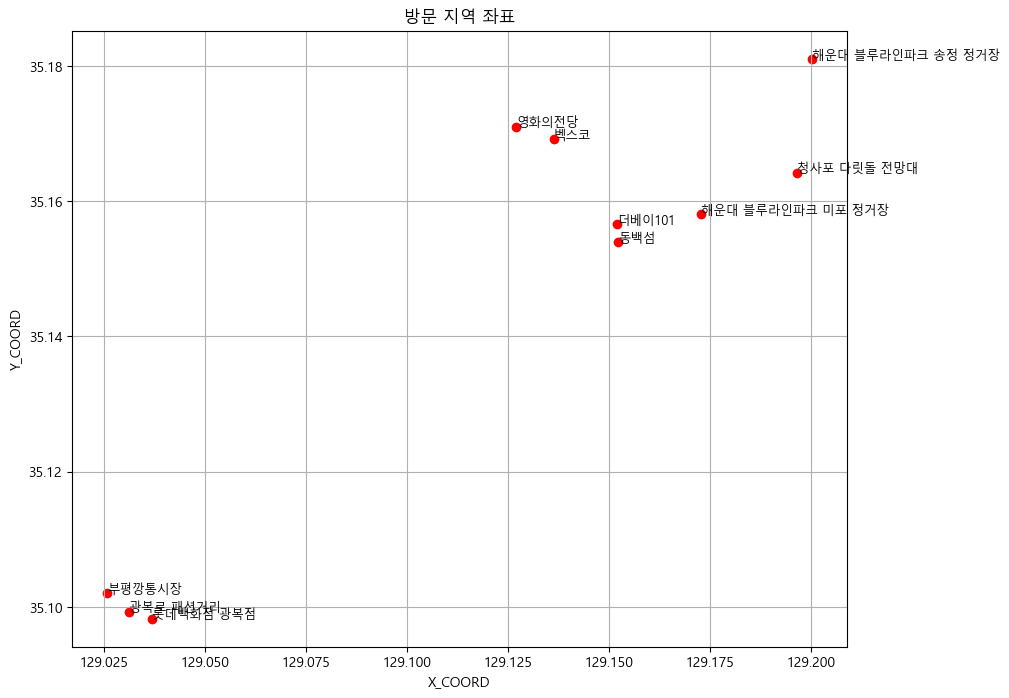

In [12]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc 

font_path = "C:/Windows/Fonts/malgun.ttf" 
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

plt.figure(figsize=(10, 8))
plt.scatter(sorted_data['X_COORD'], sorted_data['Y_COORD'], c='red', marker='o')
for i, row in sorted_data.iterrows():
    plt.text(row['X_COORD'], row['Y_COORD'], row['VISIT_AREA_NM'], fontsize=9)

plt.title('방문 지역 좌표')
plt.xlabel('X_COORD')
plt.ylabel('Y_COORD')
plt.grid(True)
plt.show()

In [32]:
sorted_data['X_COORD'].iloc[0]


129.1520211

In [54]:
import folium
from folium.plugins import MarkerCluster

map_center = (sorted_data['Y_COORD'].mean(), sorted_data['X_COORD'].mean())

map_ = folium.Map(location=map_center, zoom_start=10)
marker_cluster = MarkerCluster().add_to(map_)


In [55]:
sorted_data

,VISIT_AREA_NM,X_COORD,Y_COORD,GUNGU,population
12,더베이101,129.152021,35.156565,해운대구,378753
14,동백섬,129.152290,35.153943,해운대구,378753
27,벡스코,129.136256,35.169172,해운대구,378753
54,영화의전당,129.127011,35.171025,해운대구,378753
65,청사포 다릿돌 전망대,129.196324,35.164236,해운대구,378753
73,해운대 블루라인파크 미포 정거장,129.172820,35.158152,해운대구,378753
74,해운대 블루라인파크 송정 정거장,129.200074,35.181081,해운대구,378753
5,광복로 패션거리,129.031306,35.099295,중구,38487
18,롯데백화점 광복점,129.036851,35.098258,중구,38487
36,부평깡통시장,129.025880,35.102115,중구,38487


In [56]:
for _, row in sorted_data.iterrows():
    folium.Marker(
        location=[row['Y_COORD'], row['X_COORD']],
        popup=f"{row['VISIT_AREA_NM']}",
        tooltip=row['VISIT_AREA_NM']
    ).add_to(map_)

In [57]:
map_